# Why does a topological layering emerge in neural networks?
_An example with XOR_

## Libraries & Setup

In [1]:
import sys
sys.path.append('../')

In [2]:
from tqdm import tqdm
from math import sin, pi
from funcs import topk_mask

import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

In [3]:
from layers import CompleteLayer
from inits import Size, Like
from inits import (
    RandomNormal,
    RandomUniform,
    Ones,
    Zeros,
    Triu
)
from pruning import PruneEnsemble
from pruning import (
    NoPrune,
    RandomPrune,
    TopKPrune,
    DynamicTopK,
    ThresholdPrune,
    TriuPrune,
    TriuDamp
)
import losses
from training import train
from evals import LineVisualiser, WeightVisualiser, DirectionalityVisualiser
import experiments

In [4]:
if torch.cuda.is_available():
    try:
        _ = torch.tensor([0], device='cuda')
        device = torch.device('cuda')
    except:
        device = torch.device('cpu')
else:
    device = torch.device('cpu')

print(f'Using device: {device}')

Using device: cuda


## Generate XOR Data

In [5]:
x = torch.tensor([[0, 0], [0, 1], [1, 0], [1, 1]], dtype=torch.float32).to(device)
y = torch.unsqueeze(torch.logical_xor(x[:, 0], x[:, 1]), 1).to(torch.float32).to(device)
dataloader = DataLoader(TensorDataset(x, y), batch_size=4, shuffle=True)

## Simple Baseline

100%|██████████| 5/5 [00:04<00:00,  1.02it/s]


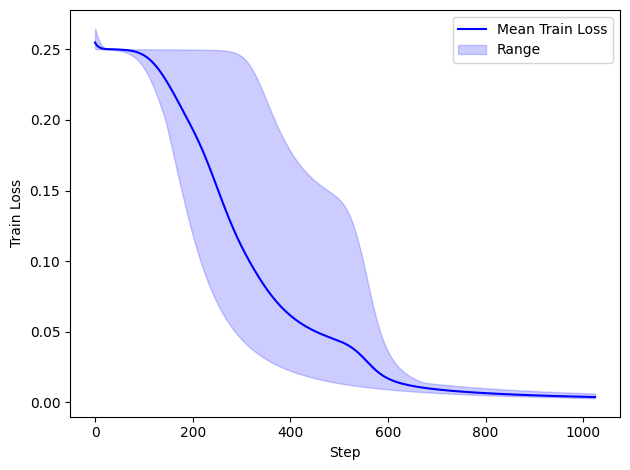

In [6]:
def baseline_setup():
    baseline = nn.Sequential(
        nn.Linear(2, 2, bias=True),
        nn.Sigmoid(),
        nn.Linear(2, 1, bias=True),
        nn.Sigmoid()
    ).to(device)
    criterion = losses.MSELoss()
    optim = torch.optim.Adam(baseline.parameters(), lr=0.01)
    return {
        'model': baseline,
        'train_criterion': criterion,
        'optimiser': optim
    }

visualisers = experiments.run(
    tries=5,
    seed=1,
    setup_fn=baseline_setup,
    visualisers={
        'line': LineVisualiser(
            lambda r: r['train_losses'],
            xlabel='Step',
            ylabel='Train Loss',
            only_values=True
        )
    },
    n_epochs=10000,
    train_dataloader=dataloader,
    early_stop=3e-3
)

## Complete Network

100%|██████████| 5/5 [00:05<00:00,  1.02s/it]

Directionality: nan $\pm$ nan



/home/yiding/Desktop/Research/induced-mlp/notebooks/../utils.py:68: RuntimeWarning: invalid value encountered in scalar divide
  directionality = 1 - min_cost / np.sum(arr)


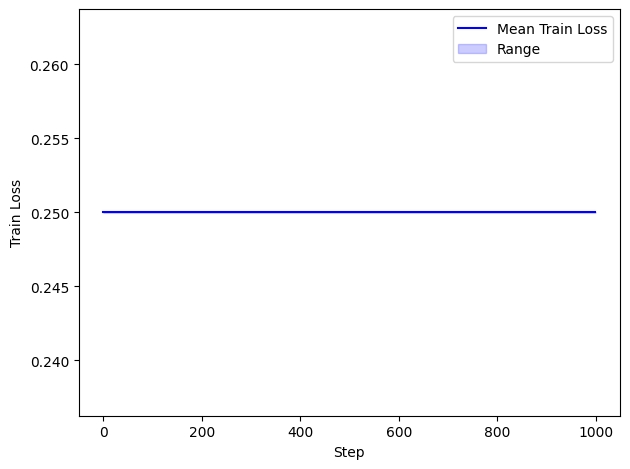

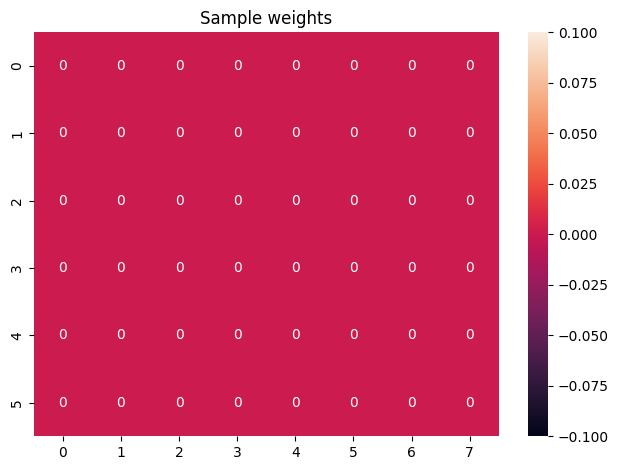

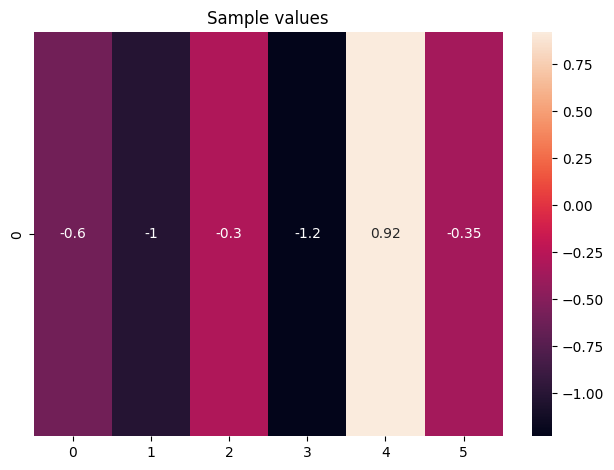

In [ ]:
def setup():
    complete = CompleteLayer(
        input_size=2,
        hidden_size=5,
        output_size=1,
        values_init=(RandomNormal, True),  # try initialising differently
        weights_init=(RandomNormal, True),
        bias_init=(Zeros, False),
        scores_init=(Ones, False),
        scores_k=1.,
        activation=F.sigmoid,
        use_bias=False
    ).to(device)
    optim = torch.optim.Adam(complete.parameters(), lr=0.01)
    return {
        'model': complete,
        'optimiser': optim
    }

visualisers, result = experiments.run(
    its=3,
    pruner=PruneEnsemble({
        'values': NoPrune(),
        'weights': NoPrune(),
    }),
    visualisers={
        'directionality': DirectionalityVisualiser(
            lambda r: r['model'].weights,
            name = 'weights',
            graphs=False
        ),
        'train': LineVisualiser(
            lambda r: r['train_losses'],
            xlabel='Step',
            ylabel='Train Loss',
            only_values=True
        ),
        # LineVisualiser(
        #     lambda r: (r['val_steps'], r['val_losses']),
        #     xlabel='Step',
        #     ylabel='Validation Loss'
        # ),
        'weights': WeightVisualiser(
            lambda r: r['model'].weights,
            name = 'weights',
            show = ['sample']  # ['mean', 'std', 'abs-mean', 'sample']
        ),
        'values': WeightVisualiser(
            lambda r: r['model'].values,
            name = 'values',
            show = ['sample']
        ),
    },
    seed=10,
    tries=5,
    n_epochs=1000,
    setup_fn=setup,
    train_dataloader=dataloader,
    train_criterion=losses.MSELoss(),
    # val_dataloader=dataloader,
    # val_criterion=losses.MSELoss(),
    early_stop=0
)